# Error correction with cat qubits

A central obstacle to building useful quantum computers is the prevalence of hardware-level noise, which corrupts quantum information long before meaningful computations can be completed. Quantum error correction addresses this challenge by encoding a single logical qubit across many noisy physical qubits, allowing errors to be detected and corrected without destroying the encoded information.

Dissipative cat qubits encode one logical qubit in the phase space of a quantum harmonic oscillator, also known as a bosonic mode. As the average photon number increases, the phase-flip error rate of a cat qubit can be suppressed exponentially, while the bit-flip error rate grows only linearly [[REF](https://arxiv.org/pdf/1907.11729)]. This asymmetry enables access to regimes of strong noise bias, where phase-flip errors can, in principle, be made arbitrarily rare, leaving bit-flip errors as the dominant remaining failure mode.

This noise bias can be exploited by concatenating cat qubits with higher-level quantum error-correcting codes that are optimized to suppress bit-flip errors. The result is a substantial reduction in the number of physical resources required to achieve fault-tolerant quantum computation, compared to architectures based on unbiased qubits.

In this challenge, you will explore how cat qubits enable significant reductions in hardware overhead for fault-tolerant quantum computing. You will also investigate novel error-correcting codes that are particularly well suited for concatenation with cat qubits, further reducing complexity and resource requirements.

**NOTE:** All subtasks in this notebook are marked with `[TODO]`. You can use Ctrl/Cmd+F to find them and make sure you do not miss any. In some places, you will also see sections labeled `# SOLUTION ===`, which indicate where you should add code to complete the task.

# 1 - Installations


Begin by uncommenting and running the cell below to install the dependencies needed for this challenge.

In [1]:
!pip install stim~=1.15
!pip install numpy~=1.0
!pip install s|cipy
!pip install pymatching~=2.0
!pip install sinter~=1.14

/bin/bash: line 1: cipy: command not found
ERROR: Could not find a version that satisfies the requirement s (from versions: none)
ERROR: No matching distribution found for s
  Using cached pymatching-2.3.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (18 kB)
Using cached pymatching-2.3.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (626 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 kB 5.0 MB/s eta 0:00:00


In [2]:
import stim
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import os
import numpy as np


print(stim.__version__)

1.15.0


# 2 - Bell states & Error Detection Codes

The following section demonstrates the creation and measurement of a bell state:

$$ \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

Then, we will use bell states as codewords for the smallest error detection code.

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

H 0
CX 0 1
M 0 1

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-



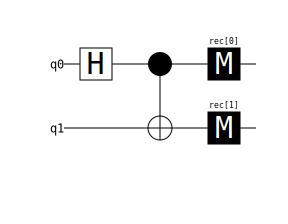

In [4]:
print(circuit)
print("")
print(circuit.diagram())
print("")
circuit.diagram('timeline-svg')

Now, we can sample this circuit and, in doing so, measure the state of each qubit.

In [5]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False]])

Here, False means 0 and True means 1. Notice how the results of the measurement qubit 0 and the measurement on qubit 1 always match, as expected of a bell state. So, we can expect a parity measurement between the two qubits to always be 0, since the two qubits will always have the same state. In stim, the parity is measured using a "DETECTOR" operation, as shown below:

In [6]:
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


In [7]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


Now, let's add X errors onto each qubit.

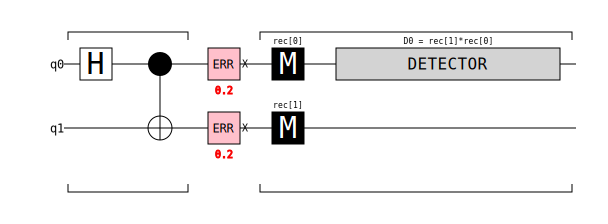

In [8]:
p = 0.2
circuit = stim.Circuit(f"""
    H 0
    CX 0 1

    TICK
    X_ERROR({p}) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

circuit.diagram('timeline-svg')

In [9]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]]


With stim, we can quickly collect many samples, extracting the detector hit rate, which should be:

$$p*(1-p)*2$$

In [10]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)
print(p*(1-p)*2)

0.319309
0.32000000000000006


## Task 2.1: Error detection code

[TODO, 10pts]: As shown, in the absence of noise the parity between the two qubits in a Bell state is fixed.

The presence of a single-qubit bit-flip error changes this parity, which appears as a nonzero detector outcome when the stabilizer $Z_0 Z_1$ is measured. This observation can be used to construct the simplest quantum error-detecting code, the two-qubit code $[[2,1,1]]$. In the notation $[[n,k,d]]$, $n$ is the number of physical qubits, $k$ is the number of logical qubits, and $d$ is the code distance. The distance $d$ is the minimum weight of a Pauli operator that preserves the codespace while acting nontrivially on the logical information.

You will now implement a $[[2,1,1]]$ code using two data qubits and one ancilla qubit to measure the stabilizer $Z_0 Z_1$. A convenient choice of logical basis states within the codespace is

$$
\ket{0_L} = \ket{\Phi^+} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}, \qquad
\ket{1_L} = \ket{\Phi^-} = \frac{\ket{00} - \ket{11}}{\sqrt{2}}.
$$

Assume that each data qubit undergoes an independent $X$ error with probability $p = 0.1$. An odd number of bit flips anticommutes with $Z_0 Z_1$ and is therefore detected by the parity check. By postselecting on runs with a trivial detector outcome (i.e. detector = False), all such odd-parity leakage error events are removed. These are denoted leakage errors, as they the qubits out of the codespace, spanned by superpositions of the codewords.


As a result, postselection suppresses all first-order physical bit-flip errors. The only remaining error process on the accepted runs is the even-parity event $X_0 X_1$, which is a logical identity operator as both codewords are in its +1 eigenbasis.

Set up this code, simulate it with X errors on each data qubit after the preparation of a bell state, and show that leakage errors and logical errors are fully suppressed with postselection on no detector events. Calculate the success probability of no detector errors occurring as a function of the physical error rate $p$ and show that it matches your simulation.

In [11]:
# SOLUTION ===
# initialize stim circuit needed for this simulation

# Assume each data qubit undergoes an independent X error with p = 0.1
# LEAKAGE ERRORS: ODD NUMBER of bit flips is detected (all removed)
# EVEN-Parity Event: X_0 X_1

# ===

p = 0.1
circuit = stim.Circuit(f"""
    H 0
    CX 0 1

    TICK
    X_ERROR({p}) 0 1
    TICK

    CX 0 2
    CX 1 2

    M 2
    DETECTOR rec[-1]
""")


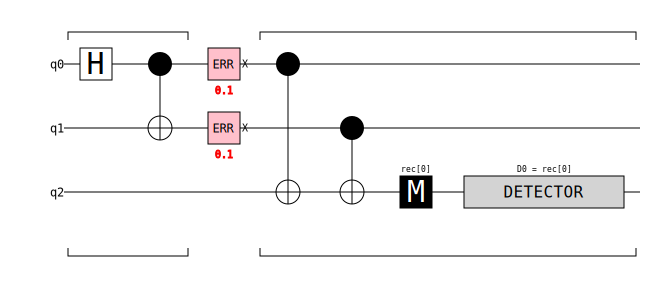

In [12]:
circuit.diagram('timeline-svg')

In [13]:

# SOLUTION ===
# run/sample simulation to calculated a simulated logical error rate

# ===

sampler = circuit.compile_detector_sampler()
results = sampler.sample(shots=10)
print(results)

simulated_logical_error_rate = None

[[ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]]


In [14]:
p = 0.1
success_prob = 1 - np.sum(sampler.sample(shots=10**6)) / 10**6
simulated_logical_error_rate = 1 - p*(1-p)*2
print("success probability:", success_prob, simulated_logical_error_rate)


# This is a code that detects leakage errors without measuring the two qubits.
# If there is an odd number of errors (leakage), it detects it and we're done: we could correct the error
# If there is an even number of errors, since it's two qubits, they're both in the same state (same parity), and for the behavior
# of this circuit it stays the same, so it's not an error

# For POSTSELECTION, would only keep shots with detector measurement false

# As such, all errors in this idealized case are detected and can be corrected




success probability: 0.81997 0.82


# 3 - Repetition Code

## Task 3.1 Implement a decoder for the repetition code.

[TODO, 5pts]: You will now implement and simulate the $n$-qubit repetition code with asymmetric distance $[[n,1,d_X=n,d_Z=1]]$, defined by the logical codewords

$$
\ket{0_L} = \ket{000\cdots 0}, \qquad
\ket{1_L} = \ket{111\cdots 1}.
$$

The stabilizer group is generated by the $n-1$ nearest-neighbor parity checks

$$
Z_i Z_{i+1}, \qquad i = 0, \dots, n-2 .
$$

These stabilizers extract $n-1$ independent bits of syndrome information, leaving exactly one protected logical degree of freedom. In other words, the code encodes a single logical qubit into $n$ physical qubits. A convenient choice of logical operators is

$$
X_L = X_0 X_1 \cdots X_{n-1}, \qquad Z_L = Z_0 \ \ (\text{equivalently any } Z_i),
$$

so the code has $X$-distance $d_X=n$ (it protects against bit-flip errors up to weight $\lfloor (n-1)/2\rfloor$) but only $Z$-distance $d_Z=1$.

Your first task is to implement a decoder that takes as input a final measurement of all data qubits together with a single round of stabilizer measurements, and outputs the most likely logical state. Rather than using a simple majority-vote rule, your decoder should explicitly use the stabilizer syndromes to infer a most likely correction consistent with the observed syndrome, apply that correction to the final data-qubit measurements, and then determine the decoded logical value. This approach is more scalable to real-time quantum error correction, where stabilizer measurements can be used to decode errors and apply corrections during an algorithm to recover back to the codespace and protect logical information.

*Note: For codes used with biased physical noise, it is often useful to specify separate distances $d_X$ (the minimum weight nontrivial logical $X$ operator) and $d_Z$ (the minimum weight nontrivial logical $Z$ operator), rather than quoting a single distance $d=\min(d_X,d_Z)$.


In [15]:
# Syndrome generator based on an input
def syndrome(input):
  output = []
  num_errors = 0

  for i in range(len(input)-1):
    if(int(input[i]) ^ int(input[i+1]) == 1):
        output.append("1")
    else:
        output.append("0")

  return "".join(output)


print(syndrome("111111001101100111011110011101111"))

00000101011010100110001010011000


In [16]:
from typing import Tuple

# IMPLEMENTATION 1, SMART MAJORITY
# When syndrome is 0, it follows that either the two bits are correct or have an error
# If the probability of an error is <0.5, it follows that it's more likely that both of the gates are correct
# Keep track of 0 and 1 pairs in input that correspond to syndrome of 0, and the majority is is most likely
def decode_repetition_code_smart_majority(
    meas: Tuple[str, str],
) -> int:

    """
    Decode an n-qubit classical repetition code (bit-flip code).

    Args:
        meas: (data_bits, stabilizer_bits)
            - data_bits: length-n string like "001" (final Z-basis measurements of data qubits)
            - stabilizer_bits: length-(n-1) string like "01" (parity checks between neighbors),
              typically s_i = data_bits[i] XOR data_bits[i+1], ordered left-to-right.
              This input is accepted but not required for majority decoding.

    Returns:
        0 or 1: decoded logical state.
    """
    assumed_0_val = 0
    assumed_1_val = 0
    p_gate = 0.1

    data = meas[0]
    stab = meas[1]
    error_output = []

    zero_pairs = []
    number_of_incongruencies = 0

    for i in range(len(stab)):
      parity = int(data[i]) ^ int(data[i+1])
      # print(f"checking {data[i]} {data[i+1]} w/ parity {parity}")
      if(parity == int(stab[i])):
        zero_pairs.append([i, i+1])
        if(p_gate < 0.5):
            if(int(data[i])):
              assumed_1_val += 1
            else:
              assumed_0_val += 1
        else:
            if(int(data[i])):
              assumed_0_val += 1
            else:
              assumed_1_val += 1
      else:
        print("INCONGRUENCY! Ending program")
        break

    return 0 if assumed_0_val > assumed_1_val else 1


# Example:
# print(decode_repetition_code(("00001", "0001")))  # -> 0
# print(decode_repetition_code(("00011", "0010")))  # -> 0
# print(decode_repetition_code(("10011", "1010")))


# First run assuming 0 val is correct, and attempt to fix
# Then run assuming 1 val is correct, and attempt to fix


print(decode_repetition_code_smart_majority(("001", "01")))

0


In [17]:
# Decode implementation with simple majority
def decode_repetition_code_majority(meas: Tuple[str, str],
) -> int:
  zeroes = meas[0].count("0")
  ones = meas[0].count("1")
  return 0 if zeroes > ones else 1

print(decode_repetition_code_majority(("001", "01")))

0


In [18]:
# Decode implementation with MWPM algorithm through PyMatch
# MWPM finds the most likely qubit errors in the in the data based on the syndrome, and flips the errors
# Then, a majority vote is used to actually find the value post fixes
import numpy as np
import pymatching

def logical_value(state: np.ndarray) -> int:
    """Return logical value by majority vote for repetition code."""
    return int(sum(state) > len(state) / 2)

def decode_repetition_code_pymatch(meas: tuple[list[str], list[str]]) -> int:
    """
    Decode a single measurement for n-qubit repetition code.

    Args:
        meas: tuple ([data, syndrome])
            data: list of '0'/'1' strings representing qubit measurements
            syndrome: list of '0'/'1' strings representing stabilizer measurements

    Returns:
        Logical value after correction (0 or 1)
    """

    # Convert string lists to int arrays
    data = np.array([int(c) for c in meas[0]])
    syndrome = np.array([int(c) for c in meas[1]])

    n = len(data)

    # Build parity-check matrix for n-qubit repetition code
    H = np.zeros((n - 1, n), dtype=int)
    for i in range(n - 1):
        H[i, i] = 1
        H[i, i + 1] = 1

    # Initialize pymatching decoder
    m = pymatching.Matching(H)

    # Decode syndrome -> qubits to flip
    error = m.decode(syndrome)

    # Apply correction to measured data
    corrected = (data + error) % 2

    # Return logical value by majority vote
    return logical_value(corrected)


print(decode_repetition_code_pymatch(("001", "01")))


0


In [19]:
## MINIMUM-WEIGHT PERFECT MATCHING ALGORITHM

In [20]:
# Random
# Smart random
# ...
# Minimum-Weight Perfect Matching Algorithm

## Task 3.2 - Simulate logical error rates

[TODO, 5pts]: Now, set up stim circuits to prepare logical $\ket{0_L}$ or $\ket{1_L}$. This circuit should contain $n$ data qubits and $n-1$ measure qubits that are used to measure parity between neighboring data qubits. Then, insert X errors on the data qubits with probability $p$ after initializing qubits to logical $\ket{0_L}$ or $\ket{1_L}$, measure the parity stabilizers $Z_{i}Z_{i+1}$ with measure qubits, and finally measure the state of each data qubit.

Then, using your decoder, decode what the logical state should be for each possible scenario. The ratio of when you decoded incorrectly over the total number of shots is your logical error probability $p_L$.

Make a plot of $p_L$ vs physical error probability (sampled logarithmically) $p \in [0.1, 0.5]$ for $n \in [3,5,7,9]$. Both axes in this plot should be on a log scale. At what value of $p$ do you see a threshold, the point where increasing $n$ helps to suppress logical errors?

In [21]:
# e.g. 3-qubit rep code

circuit = stim.Circuit('''
    R 0 1 2 3 4

    TICK
    X_ERROR(0.1) 0 2 4

    TICK
    CX 0 1 2 3

    TICK
    CX 2 1 4 3

    TICK
    MR 1 3

    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    TICK
    M 0 2 4
    OBSERVABLE_INCLUDE(0) rec[-3]
    OBSERVABLE_INCLUDE(1) rec[-2]
    OBSERVABLE_INCLUDE(2) rec[-1]
''')

In [22]:
def repetition_code_circuit(n: int, p: float = 0.1) -> stim.Circuit:
    """
    Build an n-qubit repetition code circuit.

    Layout:
      data qubits:    d[i] = 2*i          for i=0..n-1
      ancilla qubits: a[i] = 2*i + 1      for i=0..n-2  (measures Z_i Z_{i+1})

    Total qubits: 2n-1
    """
    # Guardrailing
    if n < 2:
        raise ValueError("n must be >= 2 for a repetition code.")

    data = [2*i for i in range(n)]
    anc  = [2*i+1 for i in range(n-1)]

    c = stim.Circuit()

    # Reset qubits
    c.append("R", data + anc)

    # Apply X errors to DATA qubits
    c.append("TICK")
    c.append("X_ERROR", data, p)
    c.append("TICK")

    # Measure Z_i Z_{i+1} using ancilla a[i]:
    # Two layers of CNOTs
    left_pairs  = []
    right_pairs = []
    for i in range(n-1):
        left_pairs  += [data[i],   anc[i]]
        right_pairs += [data[i+1], anc[i]]

    c.append("CX", left_pairs)
    c.append("TICK")
    c.append("CX", right_pairs)
    c.append("TICK")

    # Measure ancillas
    c.append("M", anc)

    # Finally measure all data qubits in Z
    c.append("TICK")
    c.append("M", data)

    return c


def simulate_circuit(circuit, n, num_shots=100_000):
    """
    Simulate the circuit and return counts of (data_bits, stabilizer_bits).

    Measurement order in our circuit:
      - ancillas measured first (n-1 bits)
      - data measured second (n bits)

    Returns:
      results: {(data_bits, stabilizer_bits): counts}
    """
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots=num_shots)

    results = {}
    for row in samples:
        stab = row[:n-1]
        data = row[n-1:]

        stabilizer_bits = "".join("1" if b else "0" for b in stab)
        data_bits = "".join("1" if b else "0" for b in data)

        key = (data_bits, stabilizer_bits)
        results[key] = results.get(key, 0) + 1

    return results


def logical_error_rate(
    results: dict[tuple[str, str], int],
    logical_prepared: int = 0,
    decode_algorithm=None
) -> float:
    """
    Compute logical error rate using decode_repetition_code.

    For repetition code with Z-basis final data measurements,
    logical value is 0_L = 000...0 or 1_L = 111...1 (after correction).
    """
    total = 0
    wrong = 0

    for (data_bits, stabilizer_bits), cnt in results.items():
        total += cnt
        decoded = decode_algorithm((data_bits, stabilizer_bits))
        if decoded != logical_prepared:
            wrong += cnt

    return wrong / total if total > 0 else float("nan")

In [23]:
# Example
n = 3
p = 0.1
circuit = repetition_code_circuit(n, p=p)

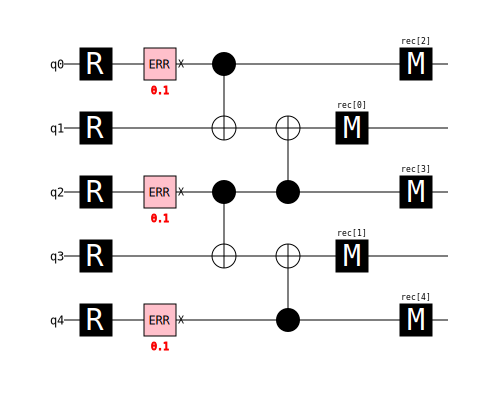

In [24]:
circuit.diagram('timeline-svg')

In [25]:
results = simulate_circuit(circuit, n)
results

{('000', '00'): 72958,
 ('110', '01'): 914,
 ('100', '10'): 8078,
 ('010', '11'): 8037,
 ('001', '01'): 8036,
 ('011', '10'): 939,
 ('101', '11'): 946,
 ('111', '00'): 92}

In [26]:
decode_algorithms = [decode_repetition_code_majority, decode_repetition_code_smart_majority, decode_repetition_code_pymatch]    # decode_repetition_

print(logical_error_rate(results, logical_prepared=0, decode_algorithm=decode_algorithms[2]))

prob_two_error = 3 * (1-p) * p * p
prob_three_error = p * p * p
sim_logical_error_rate = prob_two_error + prob_three_error

print(sim_logical_error_rate)

0.02891
0.028000000000000004


In [27]:
error_probabilities = np.logspace(-1, np.log10(0.5), 21)
distances = [3, 5, 7, 9]

# SOLUTION ===
shots = 50_000  # adjust up if you want smoother curves

pl_data = {
    alg: {n: [] for n in distances}
    for alg in range(3)
}

for alg in range(3):
  for n in distances:
      for p in error_probabilities:
          circuit = repetition_code_circuit(n, p=float(p))
          results = simulate_circuit(circuit, n, num_shots=shots)
          pl = logical_error_rate(results, logical_prepared=0, decode_algorithm=decode_algorithms[alg])
          pl_data[alg][n].append(pl)

# convert lists to numpy arrays for plotting
for alg in range(3):
  for n in distances:
      pl_data[alg][n] = np.array(pl_data[alg][n])
# ===

# 4 - Compare surface code vs cat-repetition code

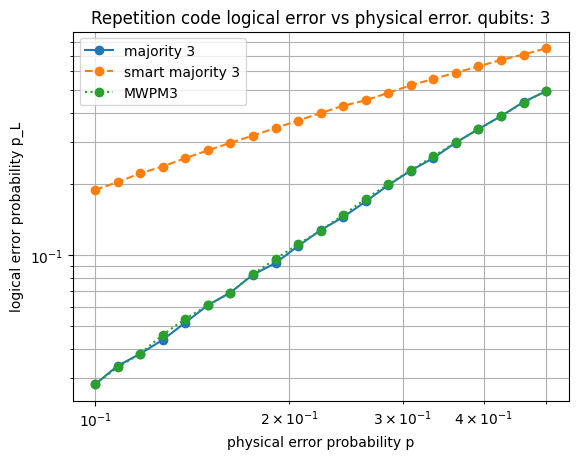

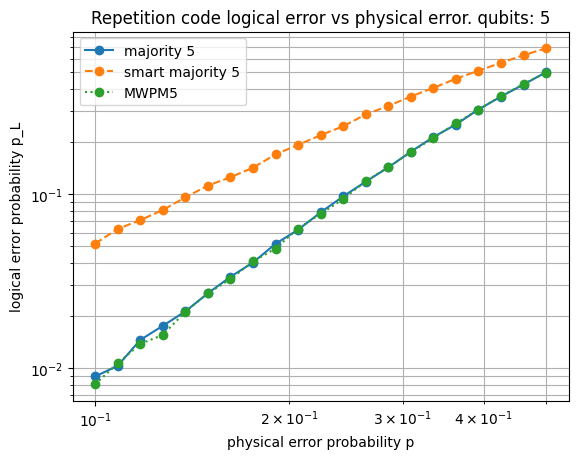

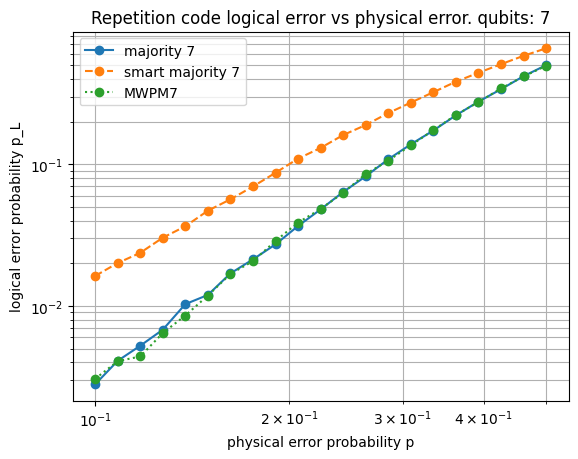

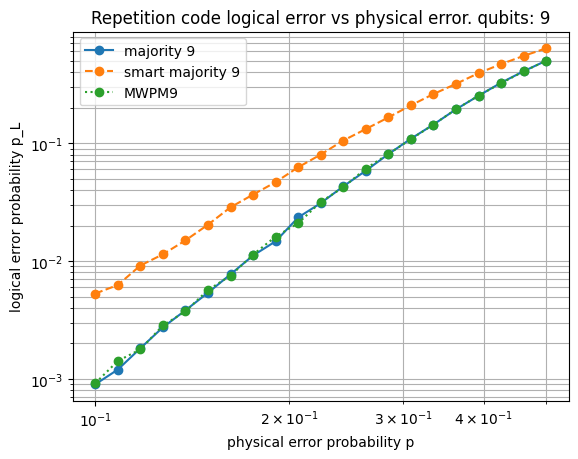

In [28]:
# SOLUTION ===
# plot results

import matplotlib.pyplot as plt

plt.figure()
for n in distances:
    plt.plot(error_probabilities, pl_data[0][n], marker='o', linestyle='-', label=f"majority {n}")
    plt.plot(error_probabilities, pl_data[1][n], marker='o', linestyle='--', label=f"smart majority {n}")
    plt.plot(error_probabilities, pl_data[2][n], marker='o', linestyle='dotted', label=f"MWPM{n}")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("physical error probability p")
    plt.ylabel("logical error probability p_L")
    plt.title(f"Repetition code logical error vs physical error. qubits: {n}")   # 0 is majority, 1 is smart majority, 2 is MWPM
    plt.legend()
    plt.grid(True, which="both")
    plt.savefig(f"rep_code_decoder_number{n}")
    plt.show()

# ===

In [29]:
# CONCLUSION FROM THESE GRAPHS: Indeed, majority and MWPM are both optimal in this case and show no difference. They show BETTER PERFORMANCE with Higher number of qubits, as expected
# Our "smart majority" experiment is everything but smart. It was worth the attempt!

In this section, we will benchmark the cat-repetition code against a conventional surface code built from unbiased qubits. While the surface code is designed to protect against general, symmetric noise, the cat-repetition code is optimized for a strongly biased error channel in which phase flips are exponentially suppressed and bit flips dominate. By comparing these two architectures under their respective noise models, we can directly evaluate the advantages of exploiting hardware bias. We will focus on resource efficiency, logical error rates, and scaling with system size to highlight when and why a bias-tailored code can outperform a more general-purpose quantum error correcting code.

Here is an especially useful resource for this section:
[https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb)

Please feel free to adapt code from the above notebook. The point of the tasks in this section is to explore logical error rates and hardware resource overheads in different parameter regimes, not figure out syntax.

## Task 4.1 - cat-repetition code threshold

Since cat qubits can exponentially suppress phase-flip errors, the dominant remaining noise channel is bit flips on the encoded qubits. In this task, you will study how the logical error rate scales with the number of cat qubits used as data qubits in a repetition code, assuming each data qubit experiences a fixed bit-flip error rate.

[TODO, 2.5pts]: First, complete `generate_rep_code_bit_flips` to return a repetition-code memory circuit with distance `d`, `3d` rounds, and bit-flip noise applied as `X_ERROR(noise)` on the data qubits. You may use Stim’s built-in repetition-code memory generator rather than implementing the circuit from scratch.

In [30]:
def generate_rep_code_bit_flips(d, noise):
    """
    Repetition-code memory circuit with:
      - distance d
      - 3d rounds
      - X-only noise on data qubits
    """
    return stim.Circuit.generated(
        "repetition_code:memory",
        distance=d,
        rounds=3 * d,
        after_clifford_depolarization=0,  # no Z noise
        before_round_data_depolarization=noise,
    )

We can then use this repetition code generation function to once again extract a threshold.

In [31]:
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

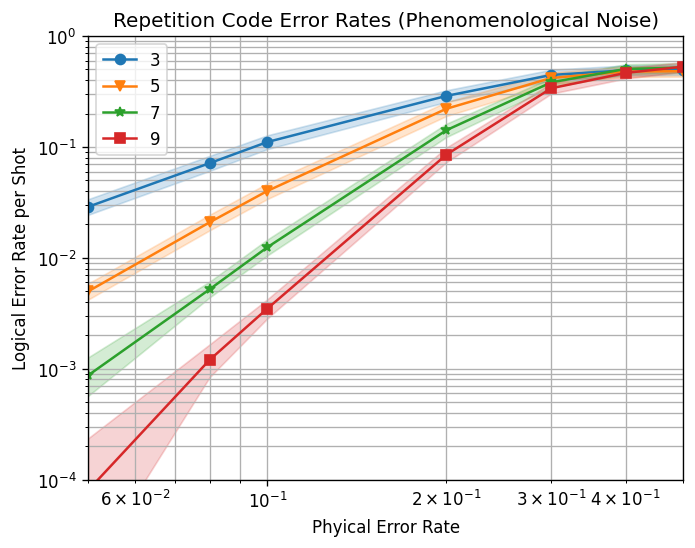

In [32]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

[TODO, 2.5pts]: Next, fix the physical bit-flip probability to $p_X = 0.01$. Assuming a cat-qubit noise bias of $10^8$, the corresponding phase-flip probability is $p_Z = 10^{-10}$. How many cat qubits are required in a repetition code to suppress the logical bit-flip probability below $10^{-10}$, so that it is comparable to the phase-flip level?

These parameter choices are loosely inspired by the following references, which provide a more detailed and rigorous analysis of error correction with cat qubits:
- [https://arxiv.org/abs/2302.06639](https://arxiv.org/abs/2302.06639)
- [https://arxiv.org/abs/2401.09541](https://arxiv.org/abs/2401.09541)

Make a plot of logical error rate versus code distance $d$ for fixed $p_X = 0.01$. Note that the code distance $d$ is equal to the number of data qubits $n$ for the repetition code. Use `generate_rep_code_bit_flips`, which injects only bit flips, since phase flips are negligible in this regime.


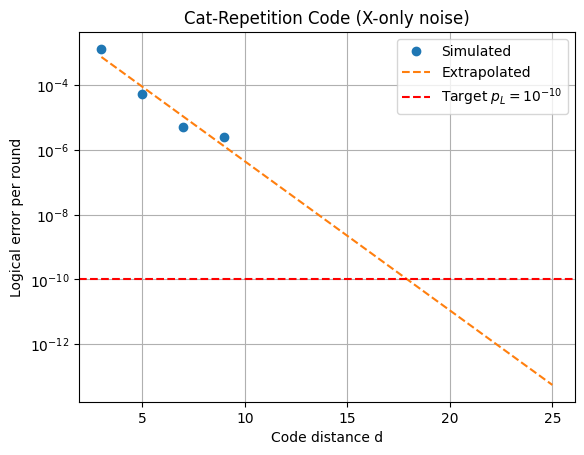

Estimated distance needed: d ≈ 17.9


In [33]:
bit_flip_prob = 0.01
noise_bias = 1e8
goal_logical_error_rate = bit_flip_prob/noise_bias


# SOLUTION ===
ds = [3, 5, 7, 9]

tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, bit_flip_prob),
        json_metadata={"d": d}
    )
    for d in ds
]

stats = sinter.collect(
    tasks=tasks,
    decoders=["pymatching"],
    num_workers=4,
    max_shots=200_000,
    max_errors=500,
)

# Extract logical error rates
d_vals = np.array([s.json_metadata["d"] for s in stats])
pL_vals = np.array(
    [
        (s.errors / s.shots) if s.errors > 0 else (0.5 / s.shots)
        for s in stats
    ],
    dtype=float
)

# Fit log(p_L) ~ a*d + b
coeffs = np.polyfit(d_vals, np.log10(pL_vals), 1)
a, b = coeffs

# Extrapolate
d_extrap = np.linspace(3, 25, 200)
pL_extrap = 10 ** (a * d_extrap + b)

plt.semilogy(d_vals, pL_vals, "o", label="Simulated")
plt.semilogy(d_extrap, pL_extrap, "--", label="Extrapolated")
plt.axhline(goal_logical_error_rate, color="red", linestyle="--",
            label=r"Target $p_L = 10^{-10}$")

plt.xlabel("Code distance d")
plt.ylabel("Logical error per round")
plt.title("Cat-Repetition Code (X-only noise)")
plt.legend()
plt.grid(True, which="both")
plt.show()

# Estimate required distance
d_required = (np.log10(goal_logical_error_rate) - b) / a
print(f"Estimated distance needed: d ≈ {d_required:.1f}")

# ===

## 4.2 - surface code benchmarks

The surface code can be viewed as a two-dimensional generalization of the repetition code that protects against both bit-flip and phase-flip errors. For this reason, many groups are pursuing surface-code architectures built from unbiased qubits (such as transmons) to suppress both types of logical errors simultaneously.

Next, we will generate an analogous plot of logical error rate versus the number of data qubits for a fixed physical depolarizing error probability of 0.001 using the surface code. From this, we will estimate how many qubits are required to reach a logical error rate of ($10^{-10}$), enabling a direct comparison with the cat-repetition results.


### 4.2.1 - surface code threshold

[TODO, 2.5pts]: First, complete `generate_surface_code_depolraizing_noise` to return a surface-code memory circuit with distance `d`, `3d` rounds, and depolarizing noise applied on data qubits. You may use Stim’s built-in surface-code memory generator and flags rather than implementing the circuit from scratch.

In [34]:
def generate_surface_code_depolarizing_noise(d: int, noise: float) -> stim.Circuit:
    """
    Surface-code memory experiment with distance d and 3d rounds,
    including:
      - depolarization after each Clifford gate (after_clifford_depolarization)
      - depolarization on data qubits before each round (before_round_data_depolarization)

    Uses rotated planar surface code measuring logical Z memory.
    """
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=int(d),
        rounds=int(3 * d),
        after_clifford_depolarization=float(noise),
        before_round_data_depolarization=float(noise),
        before_measure_flip_probability=0.0,
        after_reset_flip_probability=0.0,
    )

Then, we can use stim tooling to find the threshold for the surface code.

In [35]:
import os

surface_code_tasks = [
    sinter.Task(
        circuit = generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 2 workers...
15 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.008 
        1 pymatching <1m     997679        4777 d=3,r=9,p=0.009 
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.01  
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.011 
        0 pymatching ?·∞    1000000        5000 d=3,r=9,p=0.012 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.008
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.009
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.011
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.012
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.008
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.009
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=7,r

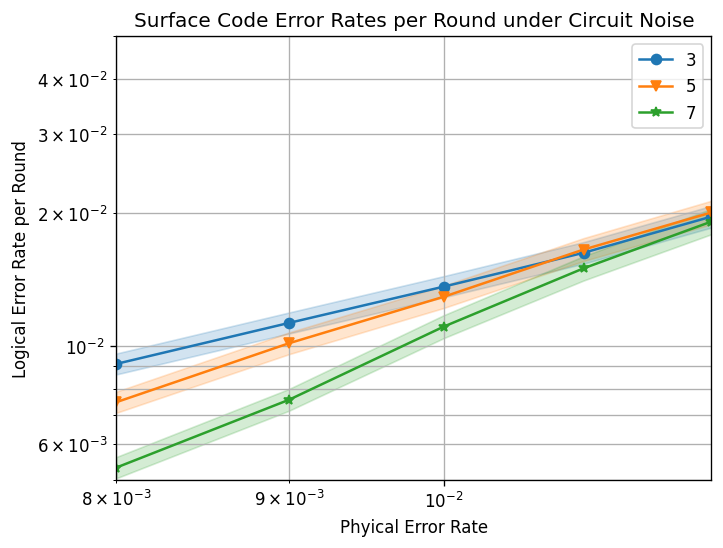

In [36]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

### 4.2.2 - estimate # of qubits for fault-tolerance

[TODO, 2.0pts]: Next, fix the depolarizing noise probability to $p = 0.001$, inspired by SOTA performance in transmon-based surface codes. As we did for the cat-repetition code, make a plot of logical error rate versus code distance $d$, which is equal to $\sqrt{n}$ for the square surface code, where $n$ is the number of data qubits. Use your `generate_surface_code_depolarizing_noise` function. The lower ylim of your plot should be `goal_logical_error_rate`.

Starting 4 workers...
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     296655         996 d=3,r=9,p=0.001 
        1 pymatching   ?     300000        1000 d=5,r=15,p=0.001
        1 pymatching   ?     300000        1000 d=7,r=21,p=0.001
        1 pymatching   ?     300000        1000 d=9,r=27,p=0.001
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     274127         971 d=3,r=9,p=0.001 
        1 pymatching <1m     294607         999 d=5,r=15,p=0.001
        1 pymatching   ?     300000        1000 d=7,r=21,p=0.001
        1 pymatching   ?     300000        1000 d=9,r=27,p=0.001
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     238287         920 d=3,r=9,p=0.001 
        1 pymatching <1m     287439         998 d=5,r=15,p=0.001
        1 pymatching <1m     298703        1000 d=7,r=21,p=0.001
        1 pymatching   ?  

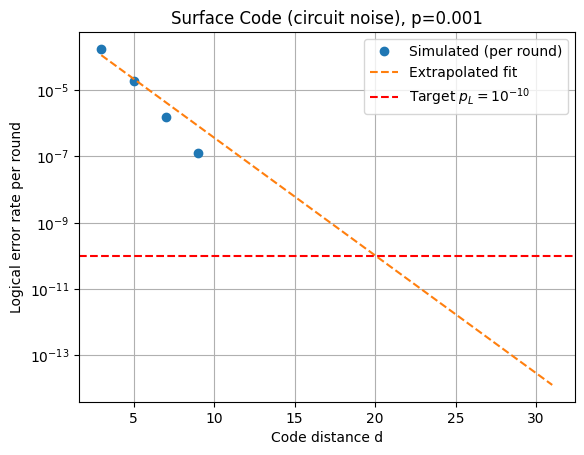

Estimated surface-code distance needed: d ≈ 20.0
Estimated data qubits ~ d^2 ≈ 401 (order-of-magnitude)


In [37]:
noise = 1e-3
goal_logical_error_rate = 1e-10

# SOLUTION ===
# Choose distances to simulate
ds = [3, 5, 7, 9]

# Build tasks (store d and r so we can normalize per round)
tasks = [
    sinter.Task(
        circuit=generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={"d": int(d), "r": int(3 * d), "p": float(noise)},
    )
    for d in ds
]

# Run collection
stats = sinter.collect(
    tasks=tasks,
    decoders=["pymatching"],
    num_workers=4,
    max_shots=300_000,
    max_errors=1_000,
    print_progress=True,
)

# Extract per-round logical error rates from stats
d_vals = []
pL_per_round = []

for s in stats:
    d = int(s.json_metadata["d"])
    r = int(s.json_metadata["r"])

    # sinter TaskStats contains: shots, errors
    # pL per shot (probability of logical failure over whole experiment)
    pL_shot = s.errors / s.shots if s.shots > 0 else 0.0

    # Convert to "per round" (approx; good for small pL)
    pL_round = pL_shot / r if r > 0 else pL_shot

    d_vals.append(d)
    pL_per_round.append(pL_round)

d_vals = np.array(d_vals, dtype=float)
pL_per_round = np.array(pL_per_round, dtype=float)

# Guard against zeros (can happen if errors=0 at larger d)
eps = 0.5 / max(s.shots for s in stats)  # ~ upper bound if 0 errors observed
pL_fit = np.maximum(pL_per_round, eps)

# Fit log10(pL) ~ a*d + b
a, b = np.polyfit(d_vals, np.log10(pL_fit), 1)

# Extrapolate
d_extrap = np.linspace(min(ds), 31, 300)
pL_extrap = 10 ** (a * d_extrap + b)

# Plot
plt.semilogy(d_vals, pL_per_round, "o", label="Simulated (per round)")
plt.semilogy(d_extrap, pL_extrap, "--", label="Extrapolated fit")
plt.axhline(goal_logical_error_rate, color="red", linestyle="--",
            label=r"Target $p_L = 10^{-10}$")

plt.xlabel("Code distance d")
plt.ylabel("Logical error rate per round")
plt.title(f"Surface Code (circuit noise), p={noise}")
plt.grid(True, which="both")
plt.legend()
plt.show()

# Estimate required distance for target
d_required = (np.log10(goal_logical_error_rate) - b) / a
print(f"Estimated surface-code distance needed: d ≈ {d_required:.1f}")
print(f"Estimated data qubits ~ d^2 ≈ {d_required**2:.0f} (order-of-magnitude)")
# ===

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sinter

noise = 1e-3
goal_logical_error_rate = 1e-10

distances = [3, 5, 7, 9, 11, 13, 15]
logical_error_rates = []

for d in distances:
    circuit = generate_surface_code_depolarizing_noise(d, noise)

    stats = sinter.collect(
        tasks=[sinter.Task(circuit=circuit)],
        decoders=["pymatching"],
        max_shots=1_000_000,
        max_errors=200,
        num_workers=4,
    )

    shots = stats[0].shots
    errors = stats[0].errors
    pL = errors / shots if shots > 0 else np.nan

    logical_error_rates.append(pL)
    print(f"d={d}, shots={shots}, errors={errors}, p_L={pL:.3e}")

d=3, shots=153668, errors=231, p_L=1.503e-03
d=5, shots=873540, errors=258, p_L=2.953e-04
d=7, shots=1000000, errors=27, p_L=2.700e-05
d=9, shots=1000000, errors=4, p_L=4.000e-06
d=11, shots=1000000, errors=1, p_L=1.000e-06
d=13, shots=1000000, errors=0, p_L=0.000e+00
d=15, shots=1000000, errors=0, p_L=0.000e+00


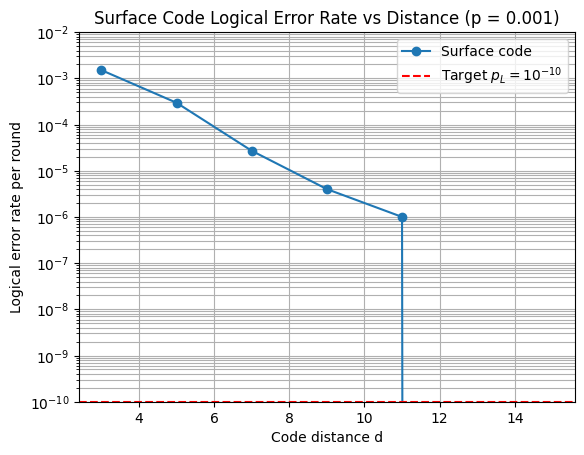

In [39]:
plt.figure()
plt.semilogy(distances, logical_error_rates, marker='o', label='Surface code')

plt.axhline(
    goal_logical_error_rate,
    color='red',
    linestyle='--',
    label=r'Target $p_L = 10^{-10}$'
)

plt.xlabel("Code distance d")
plt.ylabel("Logical error rate per round")
plt.title("Surface Code Logical Error Rate vs Distance (p = 0.001)")
plt.grid(True, which="both")
plt.legend()
plt.ylim(goal_logical_error_rate, 1e-2)
plt.show()

[TODO, 0.5pts]: Finally, compare the performance of the cat-repetition code to the surface code. In particular, comment on the resource requirements and potential challenges of both approaches.



> Cat-repetition codes leverage extreme noise bias to suppress logical X errors using 1D redundancy, achieving very low overhead in qubit connectivity and control. However, the required code distance scales linearly with the target logical error rate, leading to large qubit counts when extreme suppression is needed.

> Surface codes, while more resource-intensive per qubit and requiring 2D connectivity and full depolarizing noise tolerance, achieve exponentially better scaling with distance and ultimately require fewer qubits to reach ultra-low logical error rates.

> In practice, cat-repetition codes are well suited for near-term, biased-noise hardware, while surface codes remain the leading architecture for large-scale, universal fault-tolerant quantum computing.



# 5 - Quantum error correction inspired by classical codes

## Core Task 5.1 - Explore QEC codes inspired by classical codes

[TODO, 70pts]:

Classical error correcting codes provide a natural and powerful pathway to constructing quantum codes by directly translating classical parity checks into quantum stabilizer measurements. In particular, any linear classical code can be mapped to a quantum code that detects and corrects **bit flip (X) errors** by promoting each classical parity check into a multi-qubit ( Z )-type stabilizer. In this construction, classical codewords become logical quantum states, and the syndrome extraction process is identical in spirit to classical decoding. This approach is especially well suited for hardware with **strong noise bias**, where one error channel dominates. In our case, biased cat qubits exponentially suppress phase flip errors, leaving bit flips as the primary failure mode. As a result, we can focus entirely on X-error correction, allowing us to use a much wider and more efficient family of classical codes than would be possible for fully general quantum noise.

The final and core challenge is to choose any classical error correcting code (or family of codes), translate it into its quantum counterpart, and benchmark it against the repetition code that you already implemented. You will simulate the resulting quantum code in **Stim**, extract syndromes, perform decoding, and compare key performance metrics such as logical error rate versus number of physical qubits at a fixed physical error rate, encoding efficiency ( k/n ), the effective distance of the code and required hardware connectivity (i.e. what two-qubit gates are needed). This exploration will show how classical coding theory can be directly leveraged to design quantum codes that outperform simple repetition strategies when the noise is strongly biased.

*Optionally*, only if time permits, you may wish to demonstrate a universal, fault-tolerant set of logical gates for your code, starting with the Clifford group and extending to non-Clifford gates.


Please refer to `./2-classical-to-quantum-codes.ipynb` for a step-by-step introduction to translating a classical code into a quantum bit-flip–correcting code, along with a curated (but not exhaustive) list of classical code families to use as inspiration. You should consider this notebook required reading for the core task in this challenge.

This is an open-ended challenge, judged by the criteria specified in the `README.md` doc.

# REED SOLOMON CODES

In [ ]:
# See the notebook attached for our work on section 5! :)